In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt
from IPython.display import HTML, Latex, Math, display

In [18]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
# Valentina Guarino, mat. 978477

## <span style="color:red">  ESERCITAZIONE 7</span>

Viene simulata la dinamica di uno stato solido, liquido e gassoso dell'_**Argon**_ sottoposto ad un'interazione di Lennard-Jones 

$$V_{LJ} = 4\epsilon \big[\big(\frac{\sigma}{r}\big)^{12}-\big(\frac{\sigma}{r}\big)^6\big]$$

con $\epsilon$ unità di energia e $\sigma$ unità di lunghezza. 

La simulazione viene effettutata in un sistema canonico $(N,V,T)$ dove la temperatura $T$ è stata fissata grazie al contatto del sistema con un bagno termico. In queste condizioni la densità di probabilità di trovare il sistema in un certo stato microscopico è dato da 

$$\rho(q,p) = \frac{e^\frac{-H(q,p)}{k_B T}}{Z(V,T)}$$

dove $Z(V,T)$ è la funzione di partizione che indica il volume nello spazio delle fasi occupato dall'ensemble canonico e dove $e^\frac{-H(q,p)}{k_B T}$ è il peso di Boltzmann. Campionando il peso di Boltzmann relativo a due diverse configurazioni delle particelle attraverso un _algoritmo di Metropolis_ è possibile simulare la dinamica del sistema e valutare alcune proprietà termodinamiche, quali l'energia interna per particella, la pressione e la funzione di distribuzione a coppie.

Per compensare la mancanza dell'interazione a lungo range del potenziale, dovuta all'utilizzo di un cut-off sferico $r_c$, vengono aggiunte delle correzioni di coda nel calcolo dell'energia potenziale e del viriale (utilizzato per il calcolo della pressione):

$$<V_{LJ}> = \frac{8\pi \rho_{LJ} \epsilon}{9 r_c^9} - \frac{8\pi \rho_{LJ} \epsilon}{3 r_c^3}$$

$$\frac{<W_{LJ}>}{3 N\epsilon} = 32\pi \rho_{LJ} \Bigl[\frac{1}{9 r_c^9} - \frac{1}{6 r_c^6}\Bigr]$$

### Esercizio 7.01: Funzione di autocorrelazione e stima delle incertezze statistiche

#### Funzione di autocorrelazione

Viene valutata la funzione di autocorrelazione rispetto ai valori istantanei dell'energia interna per particella $\frac{U}{N}$ e della pressione $P$ valutate lungo $5 \cdot 10^5$ steps MonteCarlo. 

Poiché i valori generati da un algoritmo di Metropolis hanno un certo grado di correlazione, viene utilizzato il metodo a blocchi per generare risultati che siano scorrelati tra loro. Calcolando la funzione di autocorrelazione possiamo valutare la larghezza che ogni blocco dovrebbe avere di modo da azzerare la correlazione tra le misure.

Calcolando la funzione di autocorrelazione $\chi(t)$ come 

$$\chi(t) = \frac{\frac{1}{t_{max}-t}\displaystyle\sum_{t_{sim}=0}^{t_{max}-t}x(t_{sim})x(t_{sim}+t) - \frac{1}{t_{max}-t}\displaystyle\sum_{t_{sim}=0}^{t_{max}-t}x(t_{sim}) \cdot \frac{1}{t_{max}-t}\displaystyle\sum_{t_{sim}=0}^{t_{max}-t}x(t_{sim}+t)}{\frac{1}{t_{max}}\displaystyle\sum_{t_{sim}=0}^{t_{max}}x^2(t_{sim})- \Bigl(\frac{1}{t_{max}}\displaystyle\sum_{t_{sim}=0}^{t_{max}}x(t_{sim}) \Bigr)^2}$$
dove 
- $x$ indica il valore istantaneo di una quantità
- $t_{max}$ indica gli steps MonteCarlo totali (in questo caso $10^5$ MC steps)
- $t$ equivale all'intervallo di tempo oltre il quale vengono effettuate le misure

si ottengono i seguenti risultati:

In [12]:
#Calcolo della funzione di autocorrelazione per i valori istantanei di pressione-stato solido. 
pres = np.loadtxt("Solido/Pres_ist_solid.dat", usecols = 0, unpack = True)
lag = np.arange(0,300,1)
tM = len(pres)
acf_pres = []


for t in lag:
    sum_1 = 0
    sum_2 = 0
    sum_3 = 0
    sum_4 = 0
    sum_5 = 0
    for t_sim in range(0,tM - t):
        sum_1 += pres[t_sim]* pres[t_sim + t]
        sum_2 += pres[t_sim]
        sum_3 += pres[t_sim + t]
    for t_sim in range(0,tM):
        sum_4 += pres[t_sim]**2
        sum_5 += pres[t_sim]        
    ac = ((1 / (tM - t)) * sum_1 - (1 / (tM - t)) * sum_2 * (1 / (tM - t)) * sum_3) / ((1 / tM) * sum_4 - ((1 / tM) * sum_5)**2)
    acf_pres.append(ac)

In [13]:
#Calcolo della funzione di autocorrelazione dell'energia potenziale per particella-stato solido. 
epot = np.loadtxt("Solido/Epot_ist_solid.dat", usecols = 0, unpack = True)
acf_ene = []
for t in lag:
    sum_1 = 0
    sum_2 = 0
    sum_3 = 0
    sum_4 = 0
    sum_5 = 0
    for t_sim in range(0,tM - t):
        sum_1 += epot[t_sim]* epot[t_sim + t]
        sum_2 += epot[t_sim]
        sum_3 += epot[t_sim + t]
    for t_sim in range(0,tM):
        sum_4 += epot[t_sim]**2
        sum_5 += epot[t_sim]
        
    ac = ((1 / (tM - t)) * sum_1 - (1 / (tM - t)) * sum_2 * (1 / (tM - t)) * sum_3) / ((1 / tM) * sum_4 - ((1 / tM) * sum_5)**2)
    acf_ene.append(ac)

In [3]:
#Calcolo della funzione di autocorrelazione per i valori istantanei di pressione-stato liquido. 
pres = np.loadtxt("Liquido/Pres_ist.dat", usecols = 0, unpack = True)
lag = np.arange(0,300,1)
tM = len(pres)
acf_pres_liquid = []

for t in lag:
    sum_1 = 0
    sum_2 = 0
    sum_3 = 0
    sum_4 = 0
    sum_5 = 0
    for t_sim in range(0,tM - t):
        sum_1 += pres[t_sim]* pres[t_sim + t]
        sum_2 += pres[t_sim]
        sum_3 += pres[t_sim + t]
    for t_sim in range(0,tM):
        sum_4 += pres[t_sim]**2
        sum_5 += pres[t_sim]        
    ac = ((1 / (tM - t)) * sum_1 - (1 / (tM - t)) * sum_2 * (1 / (tM - t)) * sum_3) / ((1 / tM) * sum_4 - ((1 / tM) * sum_5)**2)
    acf_pres_liquid.append(ac)

In [8]:
#Calcolo della funzione di autocorrelazione dell'energia potenziale per particella-stato liquido. 
epot = np.loadtxt("Liquido/Epot_ist.dat", usecols = 0, unpack = True)
acf_ene_liquid = []

for t in lag:
    sum_1 = 0
    sum_2 = 0
    sum_3 = 0
    sum_4 = 0
    sum_5 = 0
    for t_sim in range(0,tM - t):
        sum_1 += epot[t_sim]* epot[t_sim + t]
        sum_2 += epot[t_sim]
        sum_3 += epot[t_sim + t]
    for t_sim in range(0,tM):
        sum_4 += epot[t_sim]**2
        sum_5 += epot[t_sim]
        
    ac = ((1 / (tM - t)) * sum_1 - (1 / (tM - t)) * sum_2 * (1 / (tM - t)) * sum_3) / ((1 / tM) * sum_4 - ((1 / tM) * sum_5)**2)
    acf_ene_liquid.append(ac)

In [4]:
#Calcolo della funzione di autocorrelazione per i valori istantanei di pressione-stato gassoso. 
pres = np.loadtxt("Gas/Pres_ist.dat", usecols = 0, unpack = True)
lag = np.arange(0,300,1)
tM = len(pres)
acf_pres_gas = []

for t in lag:
    sum_1 = 0
    sum_2 = 0
    sum_3 = 0
    sum_4 = 0
    sum_5 = 0
    for t_sim in range(0,tM - t):
        sum_1 += pres[t_sim]* pres[t_sim + t]
        sum_2 += pres[t_sim]
        sum_3 += pres[t_sim + t]
    for t_sim in range(0,tM):
        sum_4 += pres[t_sim]**2
        sum_5 += pres[t_sim]        
    ac = ((1 / (tM - t)) * sum_1 - (1 / (tM - t)) * sum_2 * (1 / (tM - t)) * sum_3) / ((1 / tM) * sum_4 - ((1 / tM) * sum_5)**2)
    acf_pres_gas.append(ac)

In [6]:
#Calcolo della funzione di autocorrelazione dell'energia potenziale per particella-stato gassoso. 
epot = np.loadtxt("Gas/Epot_ist.dat", usecols = 0, unpack = True)
acf_ene_gas = []

for t in lag:
    sum_1 = 0
    sum_2 = 0
    sum_3 = 0
    sum_4 = 0
    sum_5 = 0
    for t_sim in range(0,tM - t):
        sum_1 += epot[t_sim]* epot[t_sim + t]
        sum_2 += epot[t_sim]
        sum_3 += epot[t_sim + t]
    for t_sim in range(0,tM):
        sum_4 += epot[t_sim]**2
        sum_5 += epot[t_sim]
        
    ac = ((1 / (tM - t)) * sum_1 - (1 / (tM - t)) * sum_2 * (1 / (tM - t)) * sum_3) / ((1 / tM) * sum_4 - ((1 / tM) * sum_5)**2)
    acf_ene_gas.append(ac)

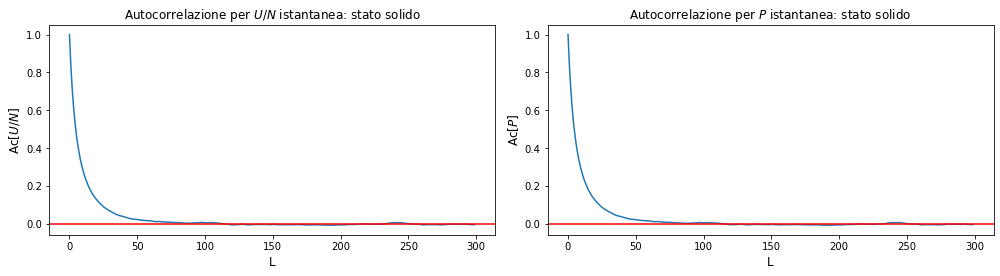

In [14]:
#Plot delle funzioni di autocorrelazione-stato solido
plt.figure(figsize=(14,7))

plt.subplot(2,2,1)
plt.plot(acf_ene)
plt.title("Autocorrelazione per $U/N$ istantanea: stato solido", fontsize = "large")
plt.xlabel("L",fontsize = "large")
plt.ylabel("Ac[$U/N$]",fontsize = "large")
plt.axhline(y = 0, color = 'red')

plt.subplot(2,2,2)
plt.plot(acf_pres)
plt.title("Autocorrelazione per $P$ istantanea: stato solido",fontsize = "large")
plt.xlabel("L",fontsize = "large")
plt.ylabel("Ac[$P$]", fontsize = "large")
plt.axhline(y = 0, color = 'red')


plt.tight_layout()
plt.show()

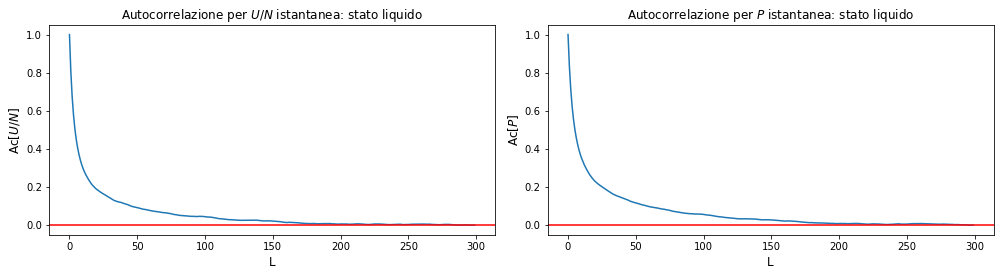

In [13]:
#Plot delle funzioni di autocorrelazione-stato liquido
plt.figure(figsize=(14,7))

plt.subplot(2,2,1)
plt.plot(acf_ene_liquid)
plt.title("Autocorrelazione per $U/N$ istantanea: stato liquido", fontsize = "large")
plt.xlabel("L",fontsize = "large")
plt.ylabel("Ac[$U/N$]",fontsize = "large")
plt.axhline(y = 0, color = 'red')

plt.subplot(2,2,2)
plt.plot(acf_pres_liquid)
plt.title("Autocorrelazione per $P$ istantanea: stato liquido",fontsize = "large")
plt.xlabel("L",fontsize = "large")
plt.ylabel("Ac[$P$]", fontsize = "large")
plt.axhline(y = 0, color = 'red')


plt.tight_layout()
plt.show()

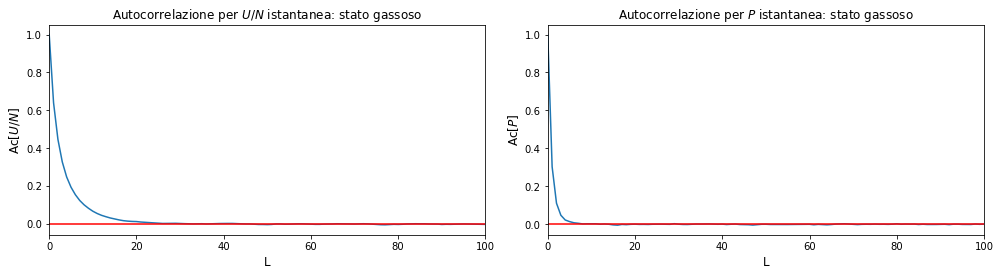

In [7]:
#Plot delle funzioni di autocorrelazione-stato gassoso
plt.figure(figsize=(14,7))

plt.subplot(2,2,1)
plt.plot(acf_ene_gas)
plt.title("Autocorrelazione per $U/N$ istantanea: stato gassoso", fontsize = "large")
plt.xlabel("L",fontsize = "large")
plt.xlim(0,100)
plt.ylabel("Ac[$U/N$]",fontsize = "large")
plt.axhline(y = 0, color = 'red')

plt.subplot(2,2,2)
plt.plot(acf_pres_gas)
plt.title("Autocorrelazione per $P$ istantanea: stato gassoso",fontsize = "large")
plt.xlabel("L",fontsize = "large")
plt.xlim(0,100)
plt.ylabel("Ac[$P$]", fontsize = "large")
plt.axhline(y = 0, color = 'red')


plt.tight_layout()
plt.show()

Come si evince dai grafici, l'autocorrelazione tra le misurazioni si annulla dopo un numero di passi variabili in base allo stato campionato. 

- Per lo stato _solido_, l'autocorrelazione della pressione e dell'energia potenziale per particella tende a zero dopo circa $100$ step MC.

- Per lo stato _liquido_, l'autocorrelazione della pressione e dell'energia potenziale per particella tende a zero dopo circa $150-200$ step MC.

- Infine per lo stato _gassoso_ si nota come l'autocorrelazione delle misure tenda rapidamente a zero: per la pressione la correlazione decade quasi istantaneamente, mentre per l'energia potenziale essa decade dopo circa $20$ passi.

#### Stima delle incertezze statistiche al variare dell'ampiezza di blocco

Si implementa un metodo a blocchi con blocchi di ampiezza variabile, da un valore di $L = 10$ fino ad $L = 5 \cdot 10^3$. Si vuole in questo modo valutare l'andamento dell'incertezza statistica $\sigma$ al variare dell'ampiezza di blocco. 

Utilizzando i dati di pressione ed energia potenziale per particella ricavati dalle simulazioni relative ai tre stati di solido, liquido e gas dell'_Argon_ si ottengono i seguenti grafici:

In [6]:
#Calcolo delle incertezze al variare della lunghezza di blocco per i valori istantanei dell'energia potenziale
N = np.array([50000, 25000, 10000, 5000, 2500, 1000, 500, 250, 100])
epot = np.loadtxt("Solido/Epot_ist_solid.dat", unpack = True)
M = epot.size
n = 0
x = np.zeros(len(N))
last_cum_mean = np.zeros(len(N))
last_err_prog = np.zeros(len(N))

#Funzione per il calcolo della deviazione standard
def Errore(mean,mean2,n):  
    if n==0:
        return 0
    else:
        return math.sqrt((mean2[n] - mean[n]**2)/n)
    
#Data blocking con blocchi di ampiezza variabile        
for i in N:
    mean = np.zeros(i)
    mean2 = np.zeros(i)
    cum_mean = np.zeros(i)
    cum_mean2 = np.zeros(i)
    err_prog = np.zeros(i)
    sum_epot = np.zeros(i)
    L = int(M / i)   
    for j in range(0,i):
        z = j * L
        for k in range(0,L):
            sum_epot[j] += epot[k+z]
        mean[j] = sum_epot[j] / L
        mean2[j] = (mean[j])**2
        
#Calcolo delle medie cumulative e dell'errore      
    for j in range(0,i):
        for k in range(j+1):
            cum_mean[j] += mean[k] 
            cum_mean2[j] += mean2[k] 
        cum_mean[j]/=(j+1) 
        cum_mean2[j]/=(j+1) 
        err_prog[j] = Errore(cum_mean,cum_mean2,j) 
#Vettori contenenti i valori finali della media cumulativa e dell'incertezza al variare degli L                
    x[n] = L                       
    last_cum_mean[n] = cum_mean[j]
    last_err_prog[n] = err_prog[j]
    n = n + 1

In [8]:
#Calcolo delle incertezze al variare della lunghezza di blocco per i valori istantanei della pressione
N = np.array([50000, 25000, 10000, 5000, 2500, 1000, 500, 250, 100])
pres = np.loadtxt("Solido/Pres_ist_solid.dat", unpack = True)
M = pres.size
n = 0
x = np.zeros(len(N))
last_cum_mean_pres = np.zeros(len(N))
last_err_prog_pres = np.zeros(len(N))

#Funzione per il calcolo della deviazione standard
def Errore(mean,mean2,n):  
    if n==0:
        return 0
    else:
        return math.sqrt((mean2[n] - mean[n]**2)/n)
    
#Data blocking con blocchi di ampiezza variabile    
for i in N:             
    mean = np.zeros(i)
    mean2 = np.zeros(i)
    cum_mean = np.zeros(i)
    cum_mean2 = np.zeros(i)
    err_prog = np.zeros(i)
    sum_pres = np.zeros(i)
    L = int(M / i)   
    for j in range(0,i):
        z = j * L
        for k in range(0,L):
            sum_pres[j] += pres[k+z]
        mean[j] = sum_pres[j] / L
        mean2[j] = (mean[j])**2
        
#Calcolo delle medie cumulative e dell'errore
    for j in range(0,i):
        for k in range(j+1):
            cum_mean[j] += mean[k] 
            cum_mean2[j] += mean2[k] 
        cum_mean[j]/=(j+1) 
        cum_mean2[j]/=(j+1) 
        err_prog[j] = Errore(cum_mean,cum_mean2,j) 
#Vettori contenenti i valori finali della media cumulativa e dell'incertezza al variare degli L        
    x[n] = L                        
    last_cum_mean_pres[n] = cum_mean[j]
    last_err_prog_pres[n] = err_prog[j]
    n = n + 1

#### Incertezze fase solida

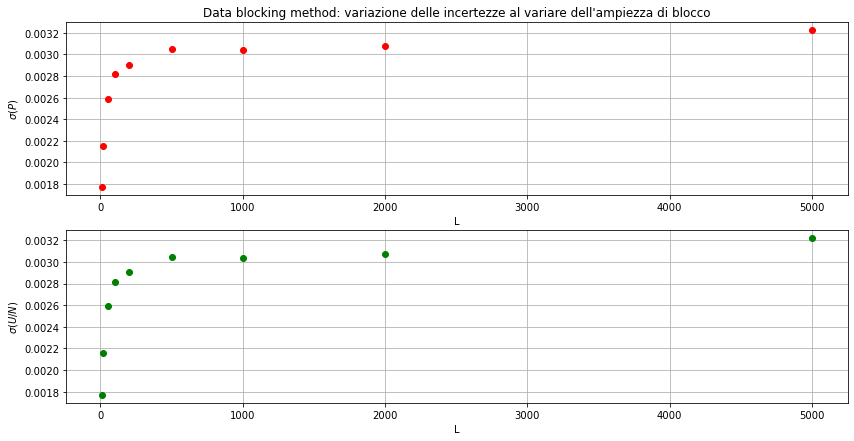

In [19]:
plt.figure(figsize = (14,7))
plt.subplot(2,1,1)
plt.title("Data blocking method: variazione delle incertezze al variare dell'ampiezza di blocco")
#plt.errorbar(x, cum_mean, yerr = err_prog,fmt = "+k:", ecolor = "red", elinewidth=1, markersize=5, capsize = 4)
plt.plot(x,last_err_prog_pres, 'o', color = "red")
plt.xlabel("L")
plt.ylabel("$\sigma(P)$")
#plt.ylabel("$E_{pot}$")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(x,last_err_prog_pres, 'o', color = "green")
plt.xlabel("L")
plt.ylabel("$\sigma(U/N)$")
plt.grid(True)

plt.show()

In [3]:
#Calcolo delle incertezze al variare della lunghezza di blocco per i valori istantanei dell'energia potenziale
N = np.array([50000, 25000, 10000, 5000, 2500, 1000, 500, 250, 100])
epot = np.loadtxt("Liquido/Epot_ist.dat", unpack = True)
M = epot.size
n = 0
x = np.zeros(len(N))
last_cum_mean = np.zeros(len(N))
last_err_prog = np.zeros(len(N))

#Funzione per il calcolo della deviazione standard
def Errore(mean,mean2,n):  
    if n==0:
        return 0
    else:
        return math.sqrt((mean2[n] - mean[n]**2)/n)
    
#Data blocking con blocchi di ampiezza variabile        
for i in N:
    mean = np.zeros(i)
    mean2 = np.zeros(i)
    cum_mean = np.zeros(i)
    cum_mean2 = np.zeros(i)
    err_prog = np.zeros(i)
    sum_epot = np.zeros(i)
    L = int(M / i)   
    for j in range(0,i):
        z = j * L
        for k in range(0,L):
            sum_epot[j] += epot[k+z]
        mean[j] = sum_epot[j] / L
        mean2[j] = (mean[j])**2
        
#Calcolo delle medie cumulative e dell'errore      
    for j in range(0,i):
        for k in range(j+1):
            cum_mean[j] += mean[k] 
            cum_mean2[j] += mean2[k] 
        cum_mean[j]/=(j+1) 
        cum_mean2[j]/=(j+1) 
        err_prog[j] = Errore(cum_mean,cum_mean2,j) 
#Vettori contenenti i valori finali della media cumulativa e dell'incertezza al variare degli L                
    x[n] = L                       
    last_cum_mean[n] = cum_mean[j]
    last_err_prog[n] = err_prog[j]
    n = n + 1

In [6]:
#Calcolo delle incertezze al variare della lunghezza di blocco per i valori istantanei della pressione
N = np.array([50000, 25000, 10000, 5000, 2500, 1000, 500, 250, 100])
pres = np.loadtxt("Liquido/Pres_ist.dat", unpack = True)
M = pres.size
n = 0
x = np.zeros(len(N))
last_cum_mean_pres = np.zeros(len(N))
last_err_prog_pres = np.zeros(len(N))

#Funzione per il calcolo della deviazione standard
def Errore(mean,mean2,n):  
    if n==0:
        return 0
    else:
        return math.sqrt((mean2[n] - mean[n]**2)/n)
    
#Data blocking con blocchi di ampiezza variabile    
for i in N:             
    mean = np.zeros(i)
    mean2 = np.zeros(i)
    cum_mean = np.zeros(i)
    cum_mean2 = np.zeros(i)
    err_prog = np.zeros(i)
    sum_pres = np.zeros(i)
    L = int(M / i)   
    for j in range(0,i):
        z = j * L
        for k in range(0,L):
            sum_pres[j] += pres[k+z]
        mean[j] = sum_pres[j] / L
        mean2[j] = (mean[j])**2
        
#Calcolo delle medie cumulative e dell'errore
    for j in range(0,i):
        for k in range(j+1):
            cum_mean[j] += mean[k] 
            cum_mean2[j] += mean2[k] 
        cum_mean[j]/=(j+1) 
        cum_mean2[j]/=(j+1) 
        err_prog[j] = Errore(cum_mean,cum_mean2,j) 
#Vettori contenenti i valori finali della media cumulativa e dell'incertezza al variare degli L        
    x[n] = L                        
    last_cum_mean_pres[n] = cum_mean[j]
    last_err_prog_pres[n] = err_prog[j]
    n = n + 1

#### Incertezze fase liquida

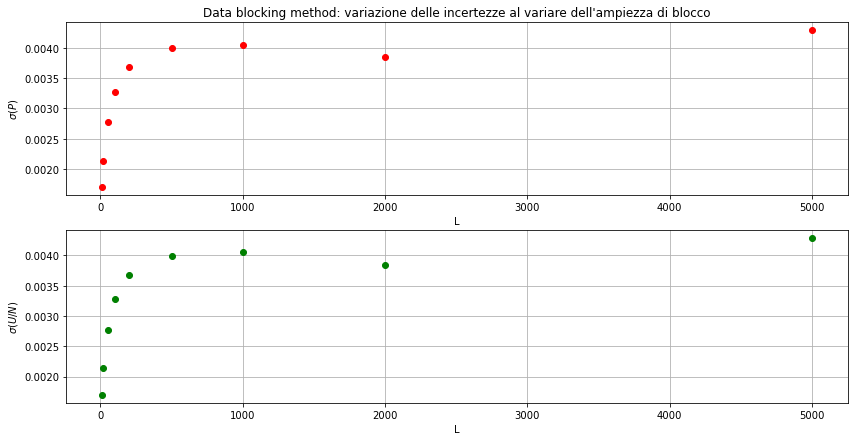

In [7]:
plt.figure(figsize = (14,7))
plt.subplot(2,1,1)
plt.title("Data blocking method: variazione delle incertezze al variare dell'ampiezza di blocco")
#plt.errorbar(x, cum_mean, yerr = err_prog,fmt = "+k:", ecolor = "red", elinewidth=1, markersize=5, capsize = 4)
plt.plot(x,last_err_prog_pres, 'o', color = "red")
plt.xlabel("L")
plt.ylabel("$\sigma(P)$")
#plt.ylabel("$E_{pot}$")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(x,last_err_prog_pres, 'o', color = "green")
plt.xlabel("L")
plt.ylabel("$\sigma(U/N)$")
plt.grid(True)

plt.show()

In [3]:
#Calcolo delle incertezze al variare della lunghezza di blocco per i valori istantanei dell'energia potenziale
N = np.array([50000, 25000, 10000, 5000, 2500, 1000, 500, 250, 100])
epot = np.loadtxt("Gas/Epot_ist.dat", unpack = True)
M = epot.size
n = 0
x = np.zeros(len(N))
last_cum_mean = np.zeros(len(N))
last_err_prog = np.zeros(len(N))

#Funzione per il calcolo della deviazione standard
def Errore(mean,mean2,n):  
    if n==0:
        return 0
    else:
        return math.sqrt((mean2[n] - mean[n]**2)/n)
    
#Data blocking con blocchi di ampiezza variabile        
for i in N:
    mean = np.zeros(i)
    mean2 = np.zeros(i)
    cum_mean = np.zeros(i)
    cum_mean2 = np.zeros(i)
    err_prog = np.zeros(i)
    sum_epot = np.zeros(i)
    L = int(M / i)   
    for j in range(0,i):
        z = j * L
        for k in range(0,L):
            sum_epot[j] += epot[k+z]
        mean[j] = sum_epot[j] / L
        mean2[j] = (mean[j])**2
        
#Calcolo delle medie cumulative e dell'errore      
    for j in range(0,i):
        for k in range(j+1):
            cum_mean[j] += mean[k] 
            cum_mean2[j] += mean2[k] 
        cum_mean[j]/=(j+1) 
        cum_mean2[j]/=(j+1) 
        err_prog[j] = Errore(cum_mean,cum_mean2,j) 
#Vettori contenenti i valori finali della media cumulativa e dell'incertezza al variare degli L                
    x[n] = L                       
    last_cum_mean[n] = cum_mean[j]
    last_err_prog[n] = err_prog[j]
    n = n + 1

In [4]:
#Calcolo delle incertezze al variare della lunghezza di blocco per i valori istantanei della pressione
N = np.array([50000, 25000, 10000, 5000, 2500, 1000, 500, 250, 100])
pres = np.loadtxt("Gas/Pres_ist.dat", unpack = True)
M = pres.size
n = 0
x = np.zeros(len(N))
last_cum_mean_pres = np.zeros(len(N))
last_err_prog_pres = np.zeros(len(N))

#Funzione per il calcolo della deviazione standard
def Errore(mean,mean2,n):  
    if n==0:
        return 0
    else:
        return math.sqrt((mean2[n] - mean[n]**2)/n)
    
#Data blocking con blocchi di ampiezza variabile    
for i in N:             
    mean = np.zeros(i)
    mean2 = np.zeros(i)
    cum_mean = np.zeros(i)
    cum_mean2 = np.zeros(i)
    err_prog = np.zeros(i)
    sum_pres = np.zeros(i)
    L = int(M / i)   
    for j in range(0,i):
        z = j * L
        for k in range(0,L):
            sum_pres[j] += pres[k+z]
        mean[j] = sum_pres[j] / L
        mean2[j] = (mean[j])**2
        
#Calcolo delle medie cumulative e dell'errore
    for j in range(0,i):
        for k in range(j+1):
            cum_mean[j] += mean[k] 
            cum_mean2[j] += mean2[k] 
        cum_mean[j]/=(j+1) 
        cum_mean2[j]/=(j+1) 
        err_prog[j] = Errore(cum_mean,cum_mean2,j) 
#Vettori contenenti i valori finali della media cumulativa e dell'incertezza al variare degli L        
    x[n] = L                        
    last_cum_mean_pres[n] = cum_mean[j]
    last_err_prog_pres[n] = err_prog[j]
    n = n + 1

#### Incertezze fase gassosa

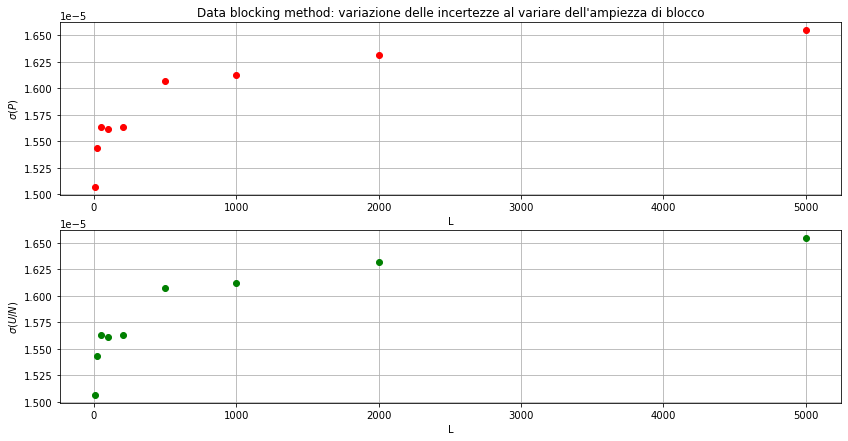

In [5]:
plt.figure(figsize = (14,7))
plt.subplot(2,1,1)
plt.title("Data blocking method: variazione delle incertezze al variare dell'ampiezza di blocco")
#plt.errorbar(x, cum_mean, yerr = err_prog,fmt = "+k:", ecolor = "red", elinewidth=1, markersize=5, capsize = 4)
plt.plot(x,last_err_prog_pres, 'o', color = "red")
plt.xlabel("L")
plt.ylabel("$\sigma(P)$")
#plt.ylabel("$E_{pot}$")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(x,last_err_prog_pres, 'o', color = "green")
plt.xlabel("L")
plt.ylabel("$\sigma(U/N)$")
plt.grid(True)

plt.show()

Per blocchi di larghezza piccola vi è una sottostima dell'incertezza; essa aumenta all'aumentare dell'ampiezza di blocco fino a saturare ad un valore limite, relativo all'ampiezza ottimale del blocco.

Dati dunque gli andamenti delle incertezze al variare dell'ampiezza di blocco e le funzioni di autocorrelazione precedentemente calcolate, si sceglie di utilizzare come ampiezza di blocco $L \simeq 5000$.

### Esercizio 7.04: Valori medi dell'energia potenziale e pressione

Vengono valutati i valor medi dell'energia potenziale $E_{pot}$ e della pressione $P$ per un modello Lennard-Jones di _**Argon**_ nelle seguenti condizioni termodinamiche:
- _Fase solida_: $\rho^\star = 1.1$, $T^\star = 0.8$, raggio di cut-off $r_c = 2.2$
- _Fase liquida_: $\rho^\star = 0.8$, $T^\star = 1.1$, raggio di cut-off $r_c = 2.5$
- _Fase gassosa_: $\rho^\star = 0.05$, $T^\star = 1.2$, raggio di cut-off $r_c = 5.0$

Utilizzando dei valori di $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K e $m=39.948$ amu si sono trasformate le varie quantità in unità del _SI_ tramite le seguenti eguaglianze:
$E_{pot} = E_{pot}^\star \cdot \epsilon$, $P = \frac{P^\star}{\sigma^3} \cdot \epsilon$

Si possono inoltre confrontare i risultati ottenuti tramite simulazione MonteCarlo con quelli ottenuti nell'_Esercitazione 4_ grazie al codice di Dinamica Molecolare, al quale sono state aggiunte le correzioni di coda; la _fase di equilibrazione_ dura **6** simulazioni per lo stato solido, **5** per lo stato liquido e **4** per lo stato gassoso. 

Per il calcolo dei valor medi si simula il sistema lungo $5 \cdot 10^5$ MC steps. Per evitare le correlazioni vengono simulati $N = 100$ blocchi, di ampiezza pari a $L = 5000$ passi per blocco.

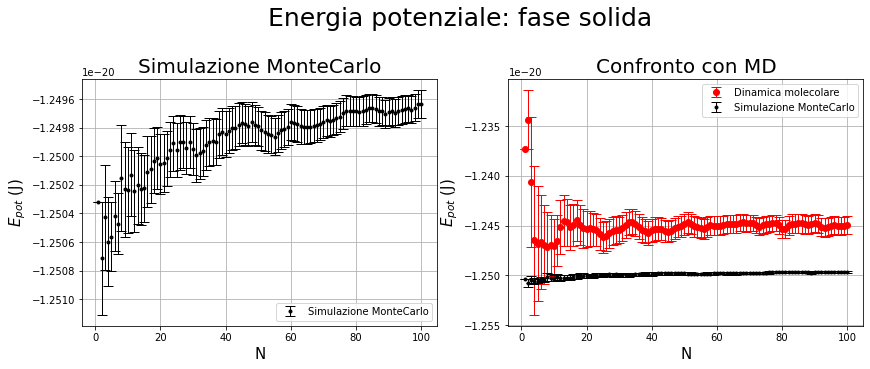

In [5]:
plt.figure(figsize=(14,10))

#Valori di conversione dalle unità di misura di Lennard-Jones
kB = 1.38 * 10**(-23)
eps = 120 * kB
sigma = 0.34 * 10**(-9)
m = 39.948 * 1.66 * 10 **(-27)

#Plot simulazione MonteCarlo
plt.suptitle("Energia potenziale: fase solida", fontsize = 25)
plt.subplot(2,2,1)
N, epot_mean, std_epot = np.loadtxt("Solido/output.epot.0", usecols = (0,2,3), unpack=True)
plt.errorbar(N, epot_mean*eps, yerr=std_epot*eps, fmt = "k.", capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.title("Simulazione MonteCarlo", fontsize = 20)
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("$E_{pot}$ (J)", fontsize = 15)
plt.legend(loc="best")

#Confronto
plt.subplot(2,2,2)
N, epot_mean_MD, std_epot_MD = np.loadtxt("Solido/Dinamica Molecolare/ave_epot.dat", usecols = (0,2,3), unpack=True)
plt.errorbar(N, epot_mean_MD*eps, yerr=std_epot_MD*eps, fmt = "ro", capsize = 5, elinewidth = 1, label = "Dinamica molecolare")
plt.errorbar(N, epot_mean*eps, yerr=std_epot*eps, fmt = "k.", capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("$E_{pot}$ (J)", fontsize = 15)
plt.title("Confronto con MD", fontsize = 20)
plt.legend(loc="best")
plt.show()

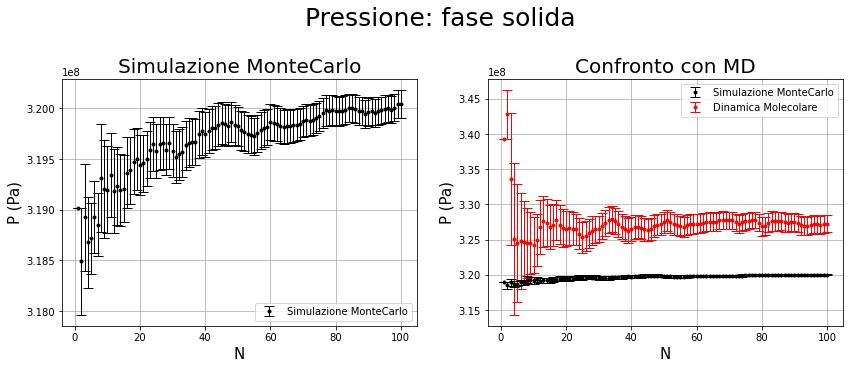

In [28]:
plt.figure(figsize=(14,10))

#Valori di conversione dalle unità di misura di Lennard-Jones
kB = 1.38 * 10**(-23)
eps = 120 * kB
sigma = 0.34 * 10**(-9)
m = 39.948 * 1.66 * 10 **(-27)

#Plot simulazione MonteCarlo
plt.suptitle("Pressione: fase solida", fontsize = 25)
plt.subplot(2,2,1)
N, pres_mean, std_pres = np.loadtxt("Solido/output.pres.0", usecols = (0,2,3), unpack=True)
plt.errorbar(N, pres_mean*(eps/sigma**3), yerr=std_pres*(eps/sigma**3), fmt = "k.", capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.title("Simulazione MonteCarlo", fontsize = 20)
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("P (Pa)", fontsize = 15)
plt.legend(loc="best")

#Confronto
plt.subplot(2,2,2)
N, pres_mean_MD, std_pres_MD = np.loadtxt("Solido/Dinamica Molecolare/ave_pres.dat", usecols = (0,2,3), unpack=True)
plt.errorbar(N, pres_mean*(eps/sigma**3), yerr=std_pres*(eps/sigma**3), fmt = "k.",capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.errorbar(N, pres_mean_MD*(eps/sigma**3), yerr=std_pres_MD*(eps/sigma**3), fmt = "r.", capsize = 5, elinewidth = 1, label = "Dinamica Molecolare")
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("P (Pa)", fontsize = 15)
plt.title("Confronto con MD", fontsize = 20)
plt.legend(loc="best")
plt.show()

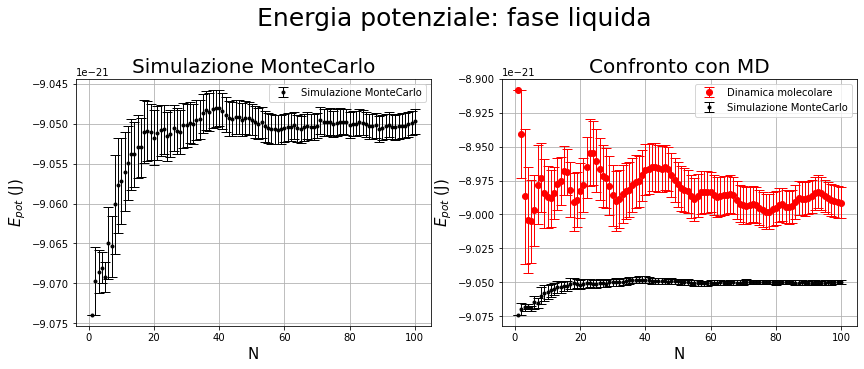

In [12]:
plt.figure(figsize=(14,10))

#Valori di conversione dalle unità di misura di Lennard-Jones
kB = 1.38 * 10**(-23)
eps = 120 * kB
sigma = 0.34 * 10**(-9)
m = 39.948 * 1.66 * 10 **(-27)

#Plot simulazione MonteCarlo
plt.suptitle("Energia potenziale: fase liquida", fontsize = 25)
plt.subplot(2,2,1)
N, epot_mean, std_epot = np.loadtxt("Liquido/output.epot.0", usecols = (0,2,3), unpack=True)
plt.errorbar(N, epot_mean*eps, yerr=std_epot*eps, fmt = "k.", capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.title("Simulazione MonteCarlo", fontsize = 20)
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("$E_{pot}$ (J)", fontsize = 15)
plt.legend(loc="best")

#Confronto
plt.subplot(2,2,2)
N, epot_mean_MD, std_epot_MD = np.loadtxt("Liquido/Dinamica Molecolare/ave_epot.dat", usecols = (0,2,3), unpack=True)
plt.errorbar(N, epot_mean_MD*eps, yerr=std_epot_MD*eps, fmt = "ro", capsize = 5, elinewidth = 1, label = "Dinamica molecolare")
plt.errorbar(N, epot_mean*eps, yerr=std_epot*eps, fmt = "k.", capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("$E_{pot}$ (J)", fontsize = 15)
plt.title("Confronto con MD", fontsize = 20)
plt.legend(loc="best")
plt.show()

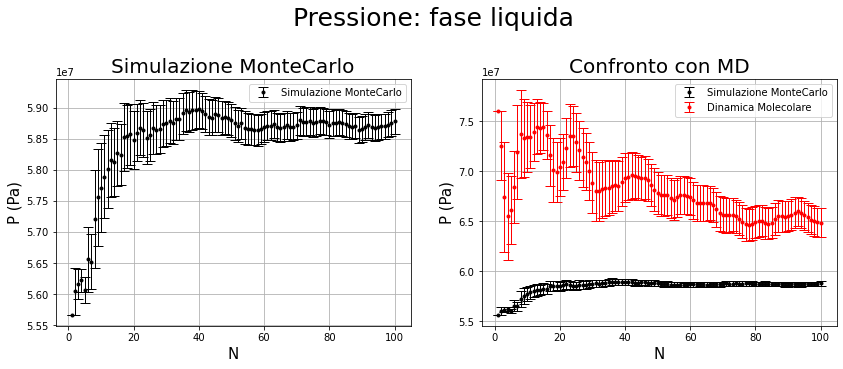

In [13]:
plt.figure(figsize=(14,10))

#Valori di conversione dalle unità di misura di Lennard-Jones
kB = 1.38 * 10**(-23)
eps = 120 * kB
sigma = 0.34 * 10**(-9)
m = 39.948 * 1.66 * 10 **(-27)

#Plot simulazione MonteCarlo
plt.suptitle("Pressione: fase liquida", fontsize = 25)
plt.subplot(2,2,1)
N, pres_mean, std_pres = np.loadtxt("Liquido/output.pres.0", usecols = (0,2,3), unpack=True)
plt.errorbar(N, pres_mean*(eps/sigma**3), yerr=std_pres*(eps/sigma**3), fmt = "k.", capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.title("Simulazione MonteCarlo", fontsize = 20)
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("P (Pa)", fontsize = 15)
plt.legend(loc="best")

#Confronto
plt.subplot(2,2,2)
N, pres_mean_MD, std_pres_MD = np.loadtxt("Liquido/Dinamica Molecolare/ave_pres.dat", usecols = (0,2,3), unpack=True)
plt.errorbar(N, pres_mean*(eps/sigma**3), yerr=std_pres*(eps/sigma**3), fmt = "k.",capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.errorbar(N, pres_mean_MD*(eps/sigma**3), yerr=std_pres_MD*(eps/sigma**3), fmt = "r.", capsize = 5, elinewidth = 1, label = "Dinamica Molecolare")
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("P (Pa)", fontsize = 15)
plt.title("Confronto con MD", fontsize = 20)
plt.legend(loc="best")
plt.show()

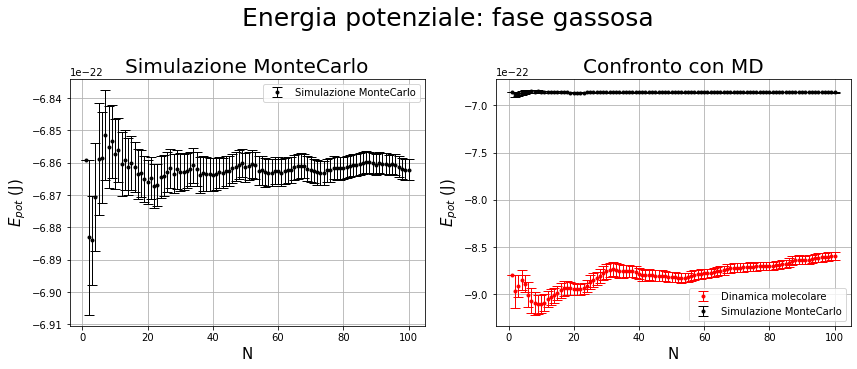

In [14]:
plt.figure(figsize=(14,10))

#Valori di conversione dalle unità di misura di Lennard-Jones
kB = 1.38 * 10**(-23)
eps = 120 * kB
sigma = 0.34 * 10**(-9)
m = 39.948 * 1.66 * 10 **(-27)

#Plot simulazione MonteCarlo
plt.suptitle("Energia potenziale: fase gassosa", fontsize = 25)
plt.subplot(2,2,1)
N, epot_mean, std_epot = np.loadtxt("Gas/output.epot.0", usecols = (0,2,3), unpack=True)
plt.errorbar(N, epot_mean*eps, yerr=std_epot*eps, fmt = "k.", capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.title("Simulazione MonteCarlo", fontsize = 20)
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("$E_{pot}$ (J)", fontsize = 15)
plt.legend(loc="best")

#Confronto
plt.subplot(2,2,2)
N, epot_mean_MD, std_epot_MD = np.loadtxt("Gas/Dinamica Molecolare/ave_epot.dat", usecols = (0,2,3), unpack=True)
plt.errorbar(N, epot_mean_MD*eps, yerr=std_epot_MD*eps, fmt = "r.", capsize = 5, elinewidth = 1, label = "Dinamica molecolare")
plt.errorbar(N, epot_mean*eps, yerr=std_epot*eps, fmt = "k.", capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("$E_{pot}$ (J)", fontsize = 15)
plt.title("Confronto con MD", fontsize = 20)
plt.legend(loc="best")
plt.show()

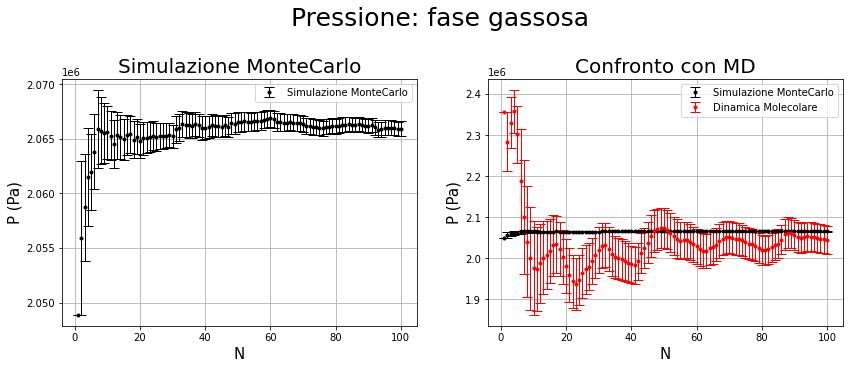

In [15]:
plt.figure(figsize=(14,10))

#Valori di conversione dalle unità di misura di Lennard-Jones
kB = 1.38 * 10**(-23)
eps = 120 * kB
sigma = 0.34 * 10**(-9)
m = 39.948 * 1.66 * 10 **(-27)

#Plot simulazione MonteCarlo
plt.suptitle("Pressione: fase gassosa", fontsize = 25)
plt.subplot(2,2,1)
N, pres_mean, std_pres = np.loadtxt("Gas/output.pres.0", usecols = (0,2,3), unpack=True)
plt.errorbar(N, pres_mean*(eps/sigma**3), yerr=std_pres*(eps/sigma**3), fmt = "k.", capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.title("Simulazione MonteCarlo", fontsize = 20)
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("P (Pa)", fontsize = 15)
plt.legend(loc="best")

#Confronto
plt.subplot(2,2,2)
N, pres_mean_MD, std_pres_MD = np.loadtxt("Gas/Dinamica Molecolare/ave_pres.dat", usecols = (0,2,3), unpack=True)
plt.errorbar(N, pres_mean*(eps/sigma**3), yerr=std_pres*(eps/sigma**3), fmt = "k.",capsize = 5, elinewidth = 1, label = "Simulazione MonteCarlo")
plt.errorbar(N, pres_mean_MD*(eps/sigma**3), yerr=std_pres_MD*(eps/sigma**3), fmt = "r.", capsize = 5, elinewidth = 1, label = "Dinamica Molecolare")
plt.grid(True)
plt.xlabel("N", fontsize = 15)
plt.ylabel("P (Pa)", fontsize = 15)
plt.title("Confronto con MD", fontsize = 20)
plt.legend(loc="best")
plt.show()

Nella simulazione MonteCarlo si ottengono risultati confrontabili con i risultati ottenuti nella simulazione di Dinamica Molecolare, seppur non convergenti. Tale comportamento può esser dovuto al fatto che, nell'_Esercitazione 4_, si è svolta la simulazione lungo $5 \cdot 10^3$ steps mentre nell'_Esercitazione 7_ lungo $5 \cdot 10^5$ MC steps. La minor lunghezza della simulazione di Dinamica Molecolare può non aver portato il sistema a convergere ai valori ottenuti con una simulazione MonteCarlo più lunga. Inoltre, essendo stati usati per entrambe le simulazioni $N=100$ blocchi, l'ampiezza dei blocchi utilizzata nella Dinamica Molecolare potrebbe non essere sufficiente a garantire delle misure totalmente scorrelate tra loro e potrebbe dunque non valere il Teorema del Limite Centrale; questo potrebbe spiegare la non convergenza ai valori trovati con la simulazione MonteCarlo per i quali, essendoci assicurati che i blocchi avessero taglia tale da garantire la non correlazione tra le misure, vale il Teorema del Limite Centrale.

### Pair distribution function per i diversi stati del sistema

La funzione di distribuzione a coppie, $g(r)$, esprime la probabilità di trovare una coppia di atomi a distanza $r$ rispettivamente alla probabilità che ci si aspetta per una distribuzione casuale di atomi che si trovano alla stessa densità. Essa indica quanto più denso è il sistema a distanza $r$ rispetto al caso del gas ideale, per cui $g(r) = 1$.

Poiché il nostro sistema risente di un potenziale interatomico a coppie del tipo 
    $$ V(\vec{r}_{1}...\vec{r}_{N}) = \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N V(|\vec{r}_{i}-\vec{r}_{j}|), \quad i \neq j$$
    
allora la funzione $g(r)$ può essere utile nell'espressione di alcune osservabili medie, come ad esempio l'energia potenziale.

Si noti come
- Vicino all'origine $g(r) = 0$: ciò è dovuto all'azione del potenziale interatomico a short-range, che non permette ai due atomi di avvicinarsi
- Per grandi distanze $g(r) \rightarrow 1$, avvicinandosi al caso del gas ideale

Nei seguenti grafici è mostrata la funzione di distribuzione a coppie per i diversi stati del sistema di argon, utilizzando la distanza di Lennard-Jones $r^\star = \frac{r}{\sigma}$. Vengono inoltre confrontati, per i diversi stati del sistema, i risultati ottenuti mediante simulazione MonteCarlo con i risultati ottenuti grazie a simulazione di Dinamica Molecolare.

#### Fase solida

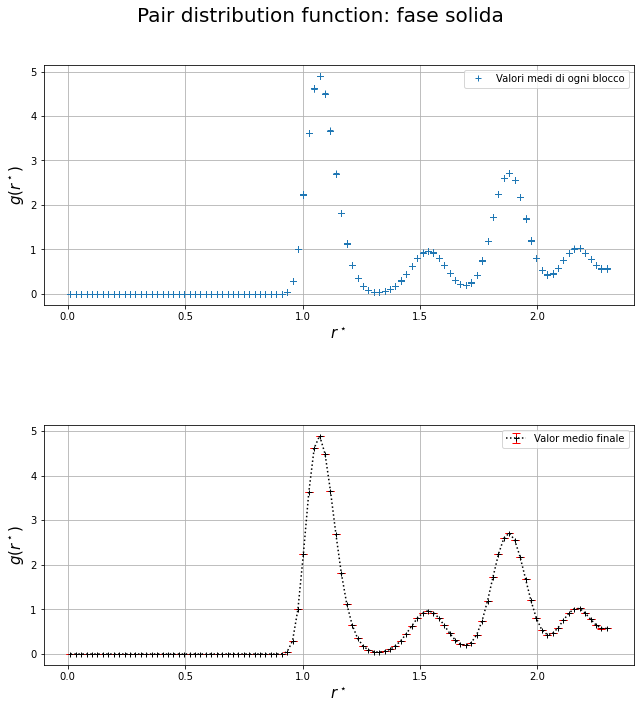

In [6]:
plt.figure(figsize=(9,10))

plt.subplot(2,1,1)
r, g_r = np.loadtxt('Solido/output.gofr.0', usecols = (1, 2), unpack = True)
plt.plot(r,g_r, "+", label = "Valori medi di ogni blocco")
plt.xlabel("$r^\star$", fontsize = 15)
plt.ylabel("$g(r^\star)$", fontsize = 15)
plt.grid(True)
plt.legend(loc="best")

plt.subplot(2,1,2)
r, g_r,std = np.loadtxt('Solido/output.gave.0', usecols = (0, 1, 2), unpack = True)
plt.errorbar(r,g_r, yerr = std, fmt = "+k:", ecolor = "red", elinewidth=1, markersize=5, 
             capsize = 4,label = "Valor medio finale")
plt.xlabel("$r^\star$", fontsize = 15)
plt.ylabel("$g(r^\star)$", fontsize = 15)
plt.legend(loc="best")
plt.grid(True)
plt.suptitle("Pair distribution function: fase solida", fontsize = 20)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.5)
plt.show()

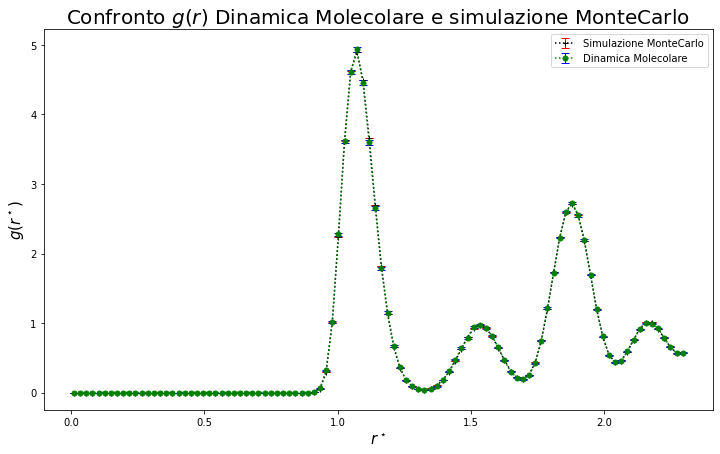

In [7]:
plt.figure(figsize=(12,7))
r, g_r,std = np.loadtxt('Solido/output.gave.0', usecols = (0, 1, 2), unpack = True)
plt.errorbar(r,g_r, yerr = std, fmt = "+k:", ecolor = "red", elinewidth=1, markersize=5, 
             capsize = 4, label = "Simulazione MonteCarlo")
rdin, g_rdin,std_din = np.loadtxt('Solido/Dinamica Molecolare/output.gave.0', usecols = (0, 1, 2), unpack = True)
plt.errorbar(rdin,g_rdin, yerr = std_din, fmt = "og:", ecolor = "blue", elinewidth=1, markersize=5, 
             capsize = 4, label = "Dinamica Molecolare")
plt.xlabel("$r^\star$", fontsize = 15)
plt.ylabel("$g(r^\star)$", fontsize = 15)
plt.legend(loc = "best")
plt.title("Confronto $g(r)$ Dinamica Molecolare e simulazione MonteCarlo", fontsize = 20)

plt.show()

#### Fase liquida

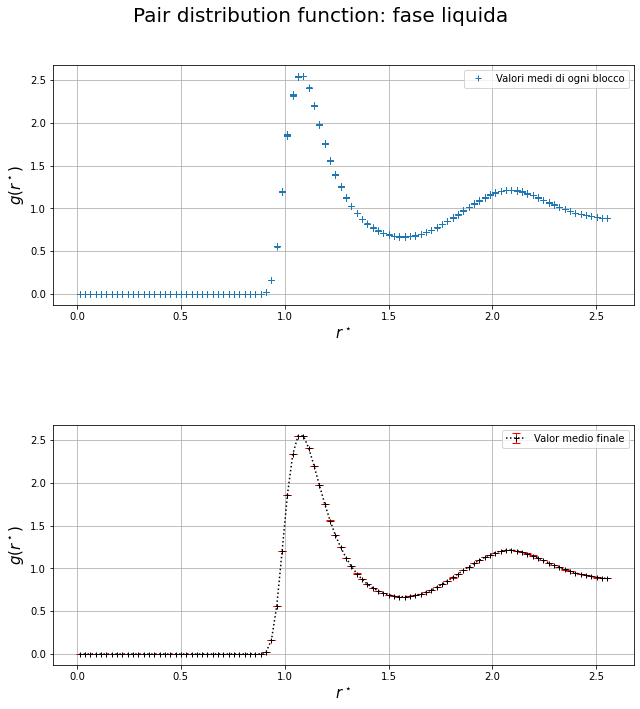

In [8]:
plt.figure(figsize=(9,10))

plt.subplot(2,1,1)
r, g_r = np.loadtxt('Liquido/output.gofr.0', usecols = (1, 2), unpack = True)
plt.plot(r,g_r, "+", label = "Valori medi di ogni blocco")
plt.xlabel("$r^\star$", fontsize = 15)
plt.ylabel("$g(r^\star)$", fontsize = 15)
plt.grid(True)
plt.legend(loc = "best")

plt.subplot(2,1,2)
r, g_r,std = np.loadtxt('Liquido/output.gave.0', usecols = (0, 1, 2), unpack = True)
plt.errorbar(r,g_r, yerr = std, fmt = "+k:", ecolor = "red", elinewidth=1, markersize=5, 
             capsize = 4, label = "Valor medio finale")
plt.xlabel("$r^\star$", fontsize = 15)
plt.ylabel("$g(r^\star)$", fontsize = 15)
plt.grid(True)
plt.legend(loc = "best")

plt.suptitle("Pair distribution function: fase liquida", fontsize = 20)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.5)
plt.show()

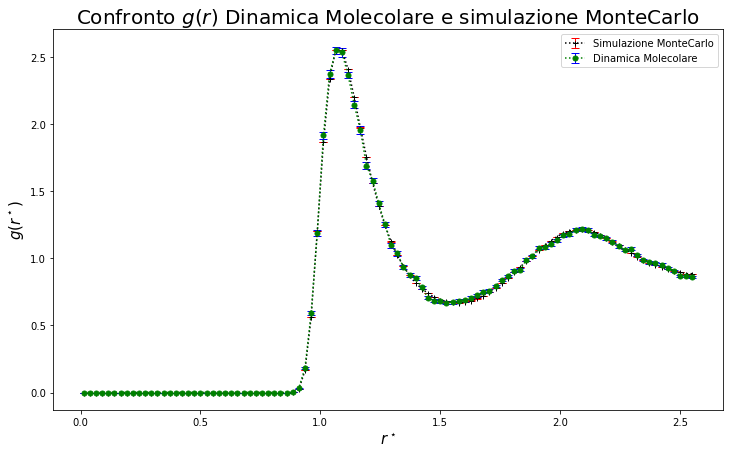

In [9]:
plt.figure(figsize=(12,7))
r, g_r,std = np.loadtxt('Liquido/output.gave.0', usecols = (0, 1, 2), unpack = True)
plt.errorbar(r,g_r, yerr = std, fmt = "+k:", ecolor = "red", elinewidth=1, markersize=5, 
             capsize = 4, label = "Simulazione MonteCarlo")
rdin, g_rdin,std_din = np.loadtxt('Liquido/Dinamica Molecolare/output.gave.0', usecols = (0, 1, 2), unpack = True)
plt.errorbar(rdin,g_rdin, yerr = std_din, fmt = "og:", ecolor = "blue", elinewidth=1, markersize=5, 
             capsize = 4, label = "Dinamica Molecolare")
plt.xlabel("$r^\star$", fontsize = 15)
plt.ylabel("$g(r^\star)$", fontsize = 15)
plt.legend(loc = "best")
plt.title("Confronto $g(r)$ Dinamica Molecolare e simulazione MonteCarlo", fontsize = 20)

plt.show()

#### Fase gassosa

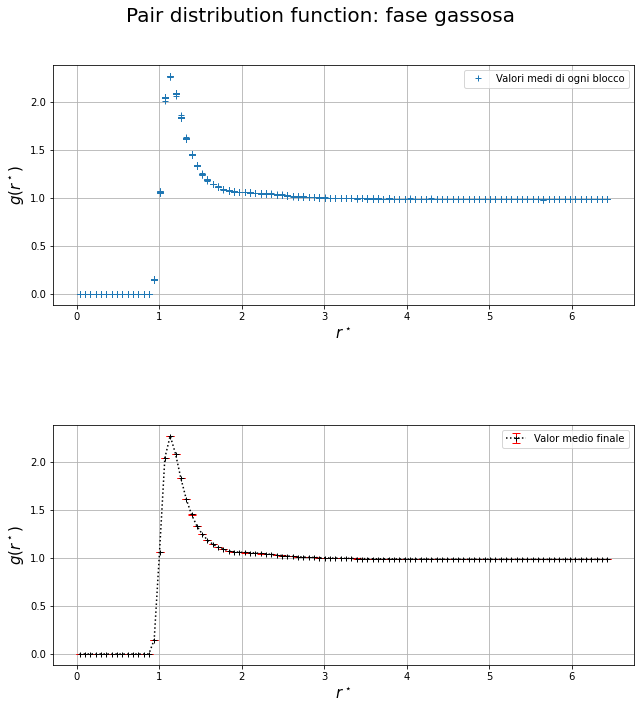

In [10]:
plt.figure(figsize=(9,10))

plt.subplot(2,1,1)
r, g_r = np.loadtxt('Gas/output.gofr.0', usecols = (1, 2), unpack = True)
plt.plot(r,g_r, "+", label = "Valori medi di ogni blocco")
plt.xlabel("$r^\star$", fontsize = 15)
plt.ylabel("$g(r^\star)$", fontsize = 15)
plt.grid(True)
plt.legend(loc="best")

plt.subplot(2,1,2)
r, g_r,std = np.loadtxt('Gas/output.gave.0', usecols = (0, 1, 2), unpack = True)
plt.errorbar(r,g_r, yerr = std, fmt = "+k:", ecolor = "red", elinewidth=1, markersize=5, 
             capsize = 4, label = "Valor medio finale")
plt.xlabel("$r^\star$", fontsize = 15)
plt.ylabel("$g(r^\star)$", fontsize = 15)
plt.grid(True)
plt.legend(loc="best")

plt.suptitle("Pair distribution function: fase gassosa", fontsize = 20)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.5)
plt.show()

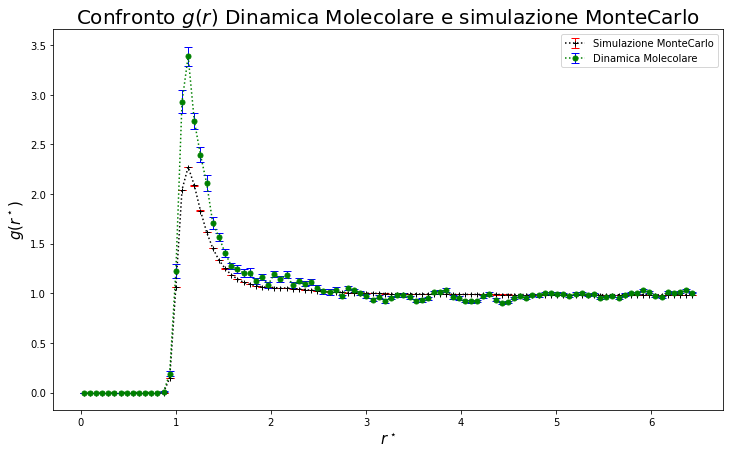

In [11]:
plt.figure(figsize=(12,7))
r, g_r,std = np.loadtxt('Gas/output.gave.0', usecols = (0, 1, 2), unpack = True)
plt.errorbar(r,g_r, yerr = std, fmt = "+k:", ecolor = "red", elinewidth=1, markersize=5, 
             capsize = 4, label = "Simulazione MonteCarlo")
rdin, g_rdin,std_din = np.loadtxt('Gas/Dinamica Molecolare/output.gave.0', usecols = (0, 1, 2), unpack = True)
plt.errorbar(rdin,g_rdin, yerr = std_din, fmt = "og:", ecolor = "blue", elinewidth=1, markersize=5, 
             capsize = 4, label = "Dinamica Molecolare")
plt.xlabel("$r^\star$", fontsize = 15)
plt.ylabel("$g(r^\star)$", fontsize = 15)
plt.legend(loc = "best")
plt.title("Confronto $g(r)$ Dinamica Molecolare e simulazione MonteCarlo", fontsize = 20)

plt.show()